In [7]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import animation
plt.rcParams['animation.embed_limit'] = 2**128
from IPython import display
from concurrent import futures
import functools
import copy

In [8]:
def conteo(historia: list()):
    acumulada = 0
    for i, renglon in enumerate(historia, 1):
        acumulada += sum(renglon)
        yield i, i**2, acumulada

In [9]:
def generar_dominio(k: int):
    #Suponemos k>=1
    tabla = [[0],
             [1]]
    for n in range(k - 1):
        unos = copy.deepcopy(tabla)
        for renglon in tabla:
            renglon.append(0)
        for renglon in unos:
            renglon.append(1)
        tabla += unos
    return [tuple(reversed(renglon)) for renglon in tabla]

In [10]:
def generar_transicion(n: int):
    """
    Genera la función de transición del autómata n-ésimo.
    """
    #Convertir a binario
    digitos = []
    while n > 0:
        n, r = divmod(n, 2)
        digitos.append(r)
        
    #Rellenar con 0 hasta alcanzar 8 digitos
    if len(digitos) < 8:
        digitos += [0]*(8-len(digitos))
    
    #Emparejar el número con el dominio
    return dict(zip(generar_dominio(3),digitos))

In [11]:
def un_paso(dic: dict, lista : list):
    
    est = []
    dic1 = dic.items()

    for i in range(len(lista)):
        for regla, estado in dic1:
            if regla == tuple(lista[i:i+3]):
                est.append(estado)

    for regla, estado in dic1:
        if regla == tuple((lista[-1],lista[0],lista[1])):
            est.insert(0, estado)
        if regla == tuple((lista[-2],lista[-1],lista[0])):
            est.append(estado)
            
    return est

In [12]:
regla_50 = generar_transicion(50)
configuracion = [0]*400 + [1] + [0]*400
historia = []
for _ in range(400):
    historia.append(configuracion.copy())
    configuracion = un_paso(regla_50, configuracion)
historia.append(configuracion.copy())

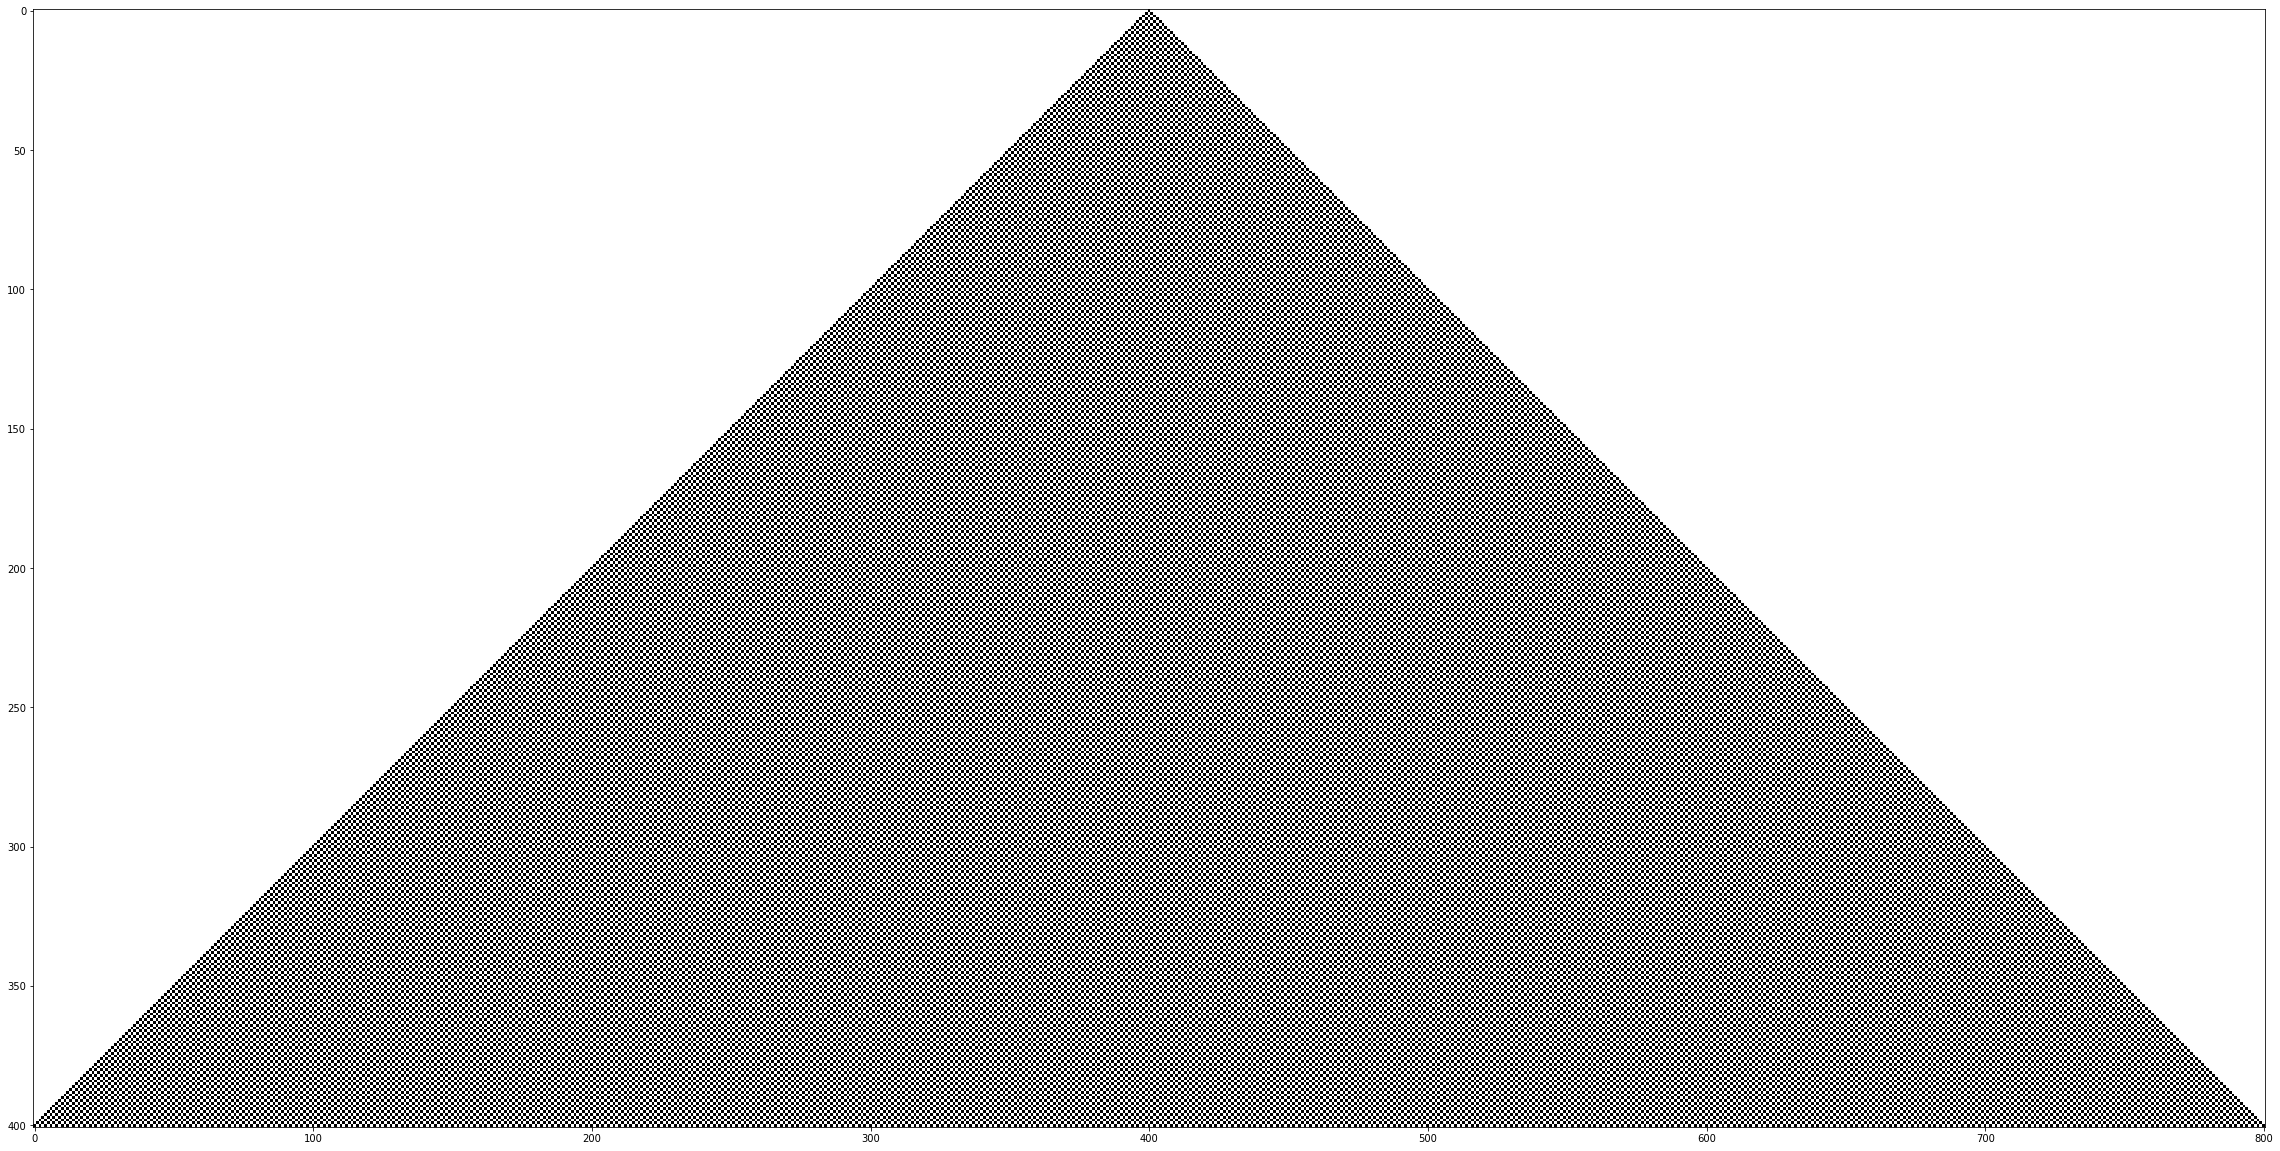

In [13]:
fig, ax = plt.subplots(figsize=(40, 40))
ax.imshow(np.array(historia, dtype=np.int8),cmap='binary')

In [14]:
x, d2, cuenta = zip(*conteo(historia))

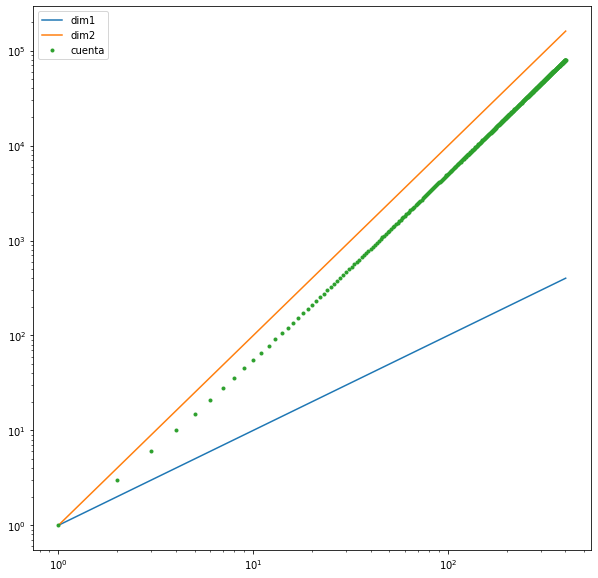

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x, x, '-', label='dim1')
ax.plot(x, d2, '-', label='dim2')
ax.plot(x, cuenta, '.', label='cuenta')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

In [16]:
regla_50 = generar_transicion(100)
configuracion = [0]*400 + [1] + [0]*400
historia = []
for _ in range(400):
    historia.append(configuracion.copy())
    configuracion = un_paso(regla_50, configuracion)
historia.append(configuracion.copy())

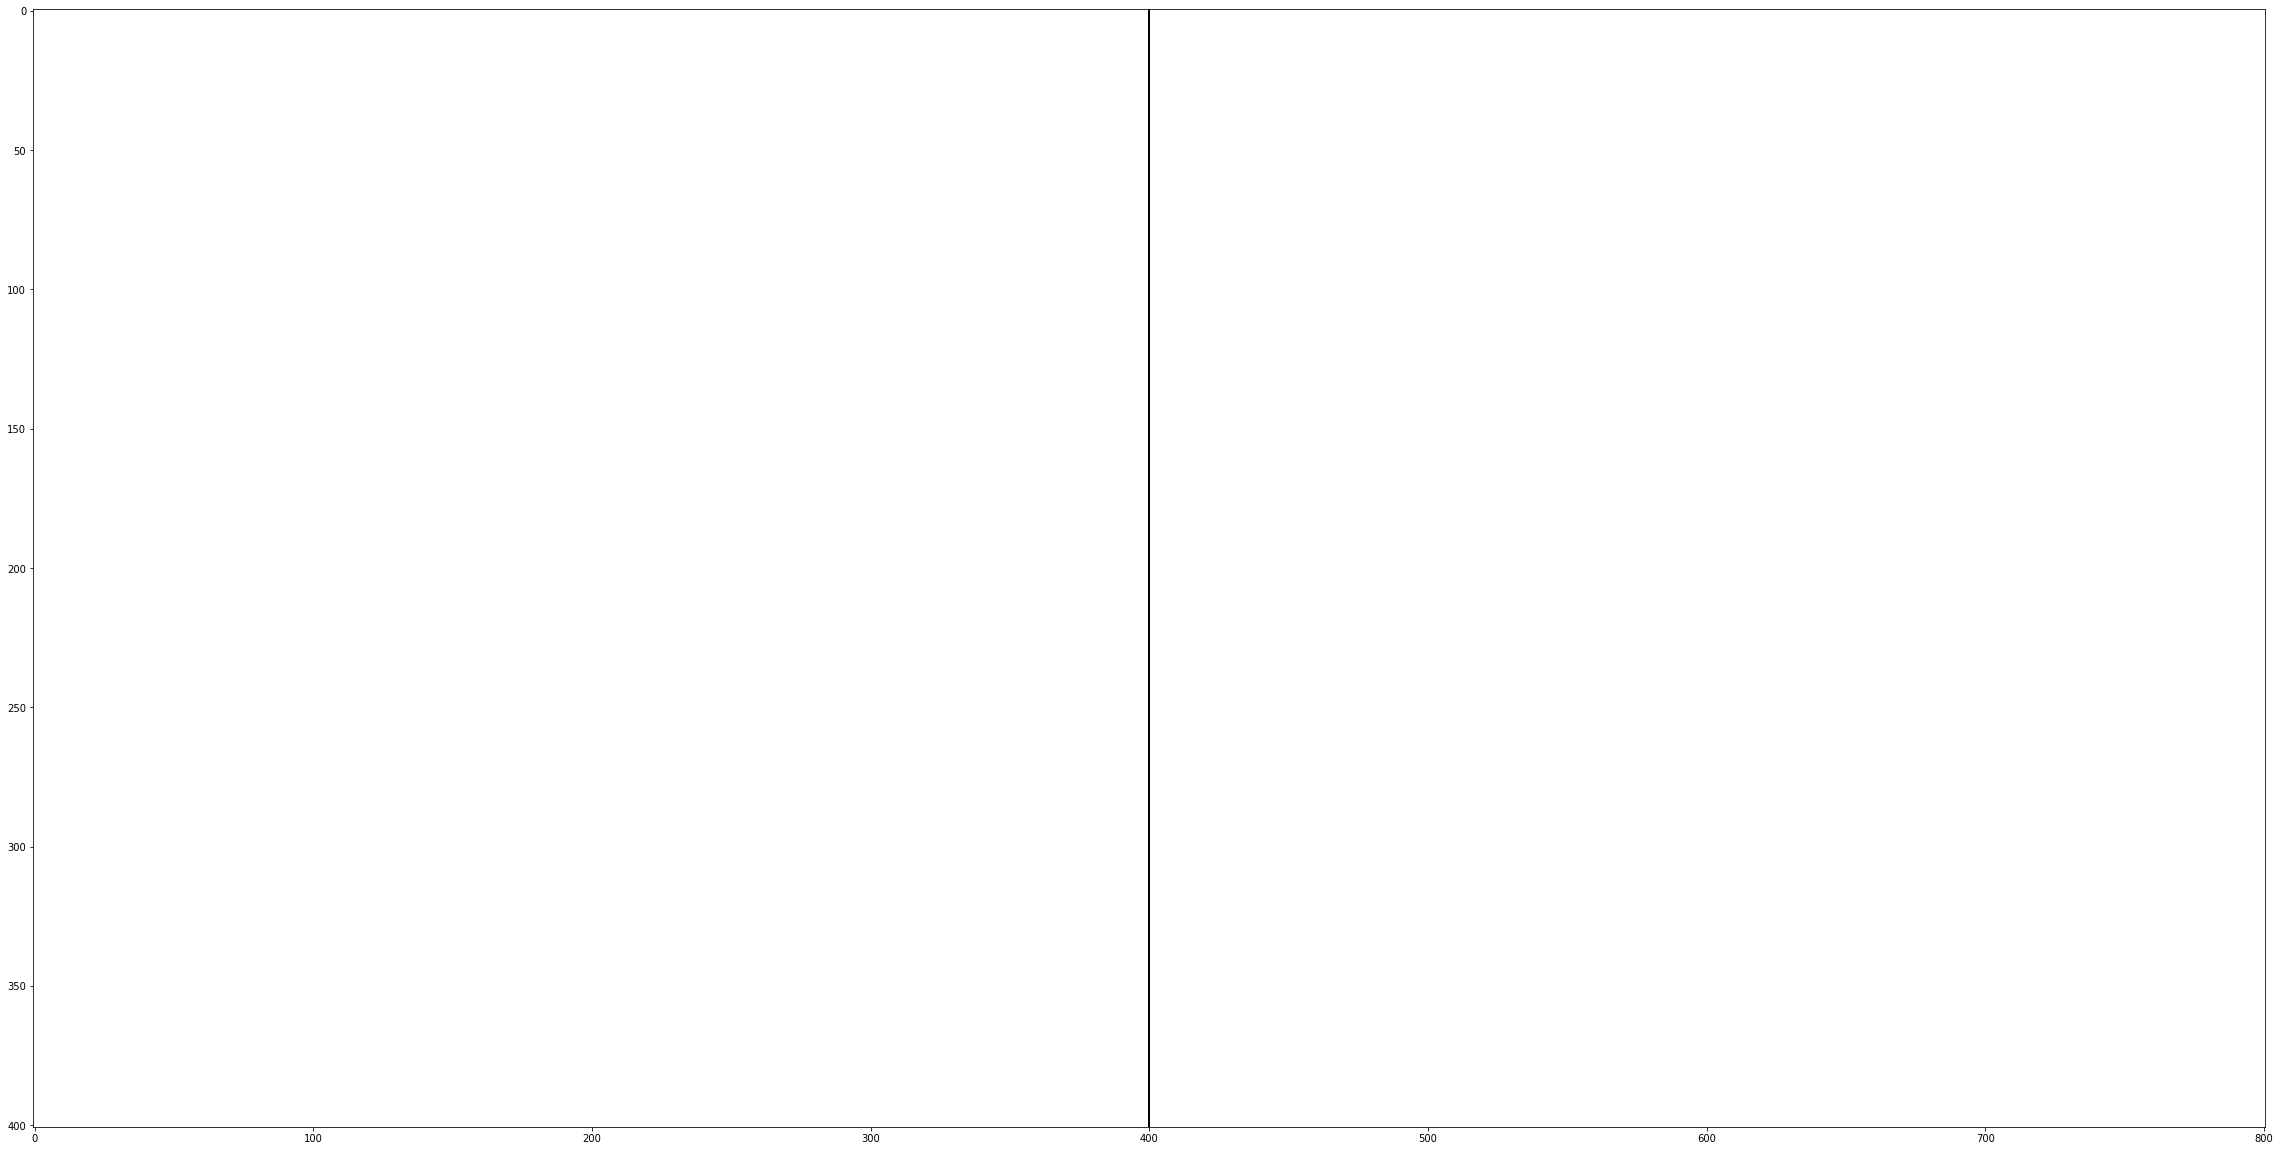

In [17]:
fig, ax = plt.subplots(figsize=(40, 40))
ax.imshow(np.array(historia, dtype=np.int8),cmap='binary')

In [18]:
x, d2, cuenta = zip(*conteo(historia))

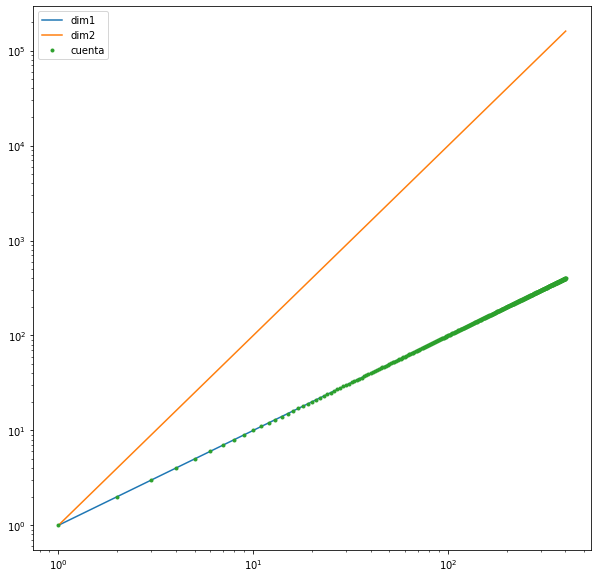

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x, x, '-', label='dim1')
ax.plot(x, d2, '-', label='dim2')
ax.plot(x, cuenta, '.', label='cuenta')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

In [20]:
regla_50 = generar_transicion(18)
configuracion = [0]*400 + [1] + [0]*400
historia = []
for _ in range(400):
    historia.append(configuracion.copy())
    configuracion = un_paso(regla_50, configuracion)
historia.append(configuracion.copy())

In [21]:
x, d2, cuenta = zip(*conteo(historia))
polinomio = np.polyfit(np.log(x), np.log(cuenta), deg=1)
regresion = np.exp(np.polyval(polinomio, np.log(x)))

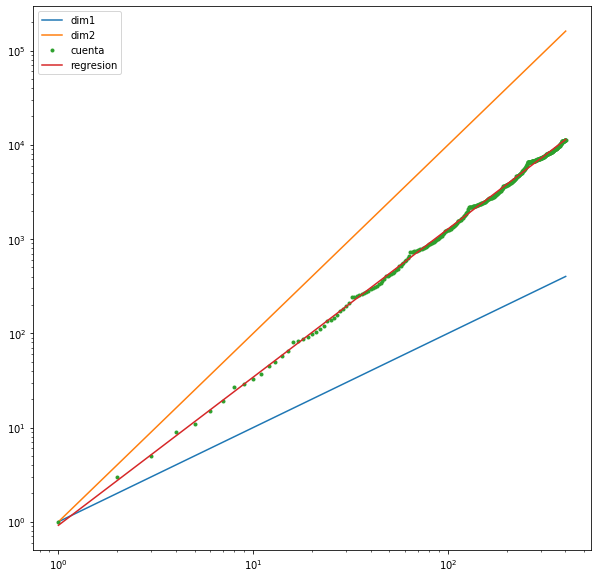

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x, x, '-', label='dim1')
ax.plot(x, d2, '-', label='dim2')
ax.plot(x, cuenta, '.', label='cuenta')
ax.plot(x, regresion, '-', label='regresion')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

Once 
 
 Loop 
 
 Reflect

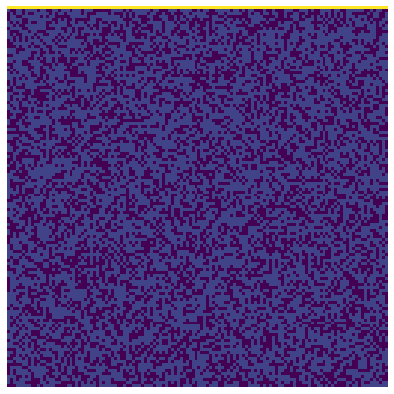

In [23]:
n = 128
q = 0.60
A = (np.random.random(size = (n, n)) <= q).astype(int)
A[0] = 5

w = np.array([
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0]
    ])

def paso_percolacion(A, w):
    c = signal.correlate2d(A, w, mode='same')
    A[(A==1)&(c>=5)]=5
    
def actualizar_animacion(i):
    global A
    if i == 0:
        A = (np.random.random(size = (n - 1, n)) <= q).astype(int)
        A = np.vstack([[5]*n, A])
    else:
        c = signal.correlate2d(A, w, mode='same')
        A[(A==1)&(c>=5)]=5
    imagen.set_array(A)
    
# crear figura
fig, ax = plt.subplots(figsize=(7,7))
ax.set_axis_off()
imagen = ax.imshow(A, vmin=0, vmax=5)
    
anim = animation.FuncAnimation(fig, actualizar_animacion, frames=2*n-1, interval=1000/24)
display.display_html(anim.to_jshtml(), raw=True)

In [24]:
w = np.array([
    [0.0, 1.0, 0.0],
    [1.0, 0.0, 1.0],
    [0.0, 1.0, 0.0]
    ])

def simular_percolacion(n, q, w=w):
    A = (np.random.random(size = (n - 1, n)) <= q).astype(np.int_)
    A = np.vstack([[5]*n, A])
    while True:
        c = signal.correlate2d(A, w, mode='same')
        cambio = (A==1)&(c>=5)
        if np.all(~cambio):
            return False
        A[cambio]=5
        if np.any(A[n-1]==5):
            return True

In [25]:
def probabilidad_grupo_percolacion(n, q, w=w, iters=1000):
    func = functools.partial(simular_percolacion, q=q, w=w)
    with futures.ProcessPoolExecutor(max_workers=8) as ejecutor:
        resultados = list(ejecutor.map(func, [n]*iters, chunksize=iters//20))
    return sum(resultados)/iters

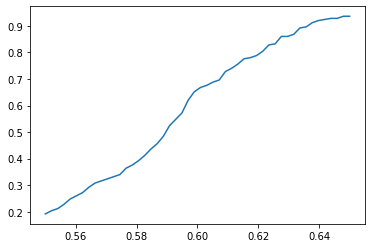

In [26]:
lista_q = np.linspace(0.55, 0.65, num=50)
probabilidades = [probabilidad_grupo_percolacion(32, q) for q in lista_q]
fig, ax = plt.subplots()
ax.plot(lista_q, probabilidades)

In [27]:
def simular_percolacion(n, q, w=w):
    A = (np.random.random(size = (n - 1, n)) <= q).astype(np.int_)
    A = np.vstack([[5]*n, A])
    while True:
        c = signal.correlate2d(A, w, mode='same')
        cambio = (A==1)&(c>=5)
        if np.all(~cambio):
            break
        A[cambio]=5
        if np.any(A[n-1]==5):
            break
    return np.sum(A==5) - n

In [28]:
tamaños = list(range(1, 129))
q = .66

In [29]:
res = []
l = []
for n in tamaños:
    for i in range(5):
        num_filled = simular_percolacion(n, q)
        res.append(num_filled)
    l.append(res)
    res = []

No handles with labels found to put in legend.


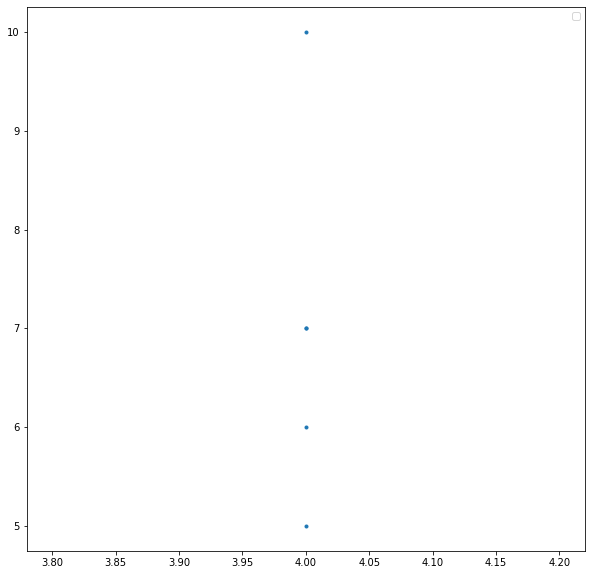

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot([i for _ in range(5)], l[3], '. ')

ax.legend()

In [31]:
x = list(i for i in range(1, 129))
d2 = list(i**2 for i in range(1, 129))

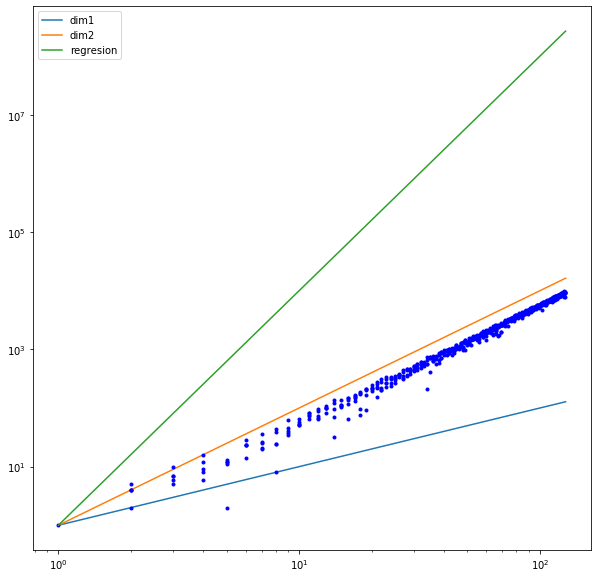

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x, x, '-', label='dim1')
ax.plot(x, d2, '-', label='dim2')
for i in range(len(l)):
    y = l[i]
    ax.plot([i for _ in range(5)], y, '. ',color='b')
polinomio = np.polyfit(np.log(x), np.log(d2), deg=1)
regresion = np.exp(np.polyval(polinomio, np.log(d2)))
ax.plot(x, regresion, '-', label='regresion')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()